In [1]:
import SfM_opencv as sfmcv2
import utils as ut 
import SfM_numpy as sfmnp

import matplotlib.pyplot as plt 
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D

import cv2 
import numpy as np 

%load_ext autoreload
%autoreload 2

# 1. Epipolar Geometry

## 1.0. Reading a pair of images, and comparing SIFT matches

<IPython.core.display.Javascript object>


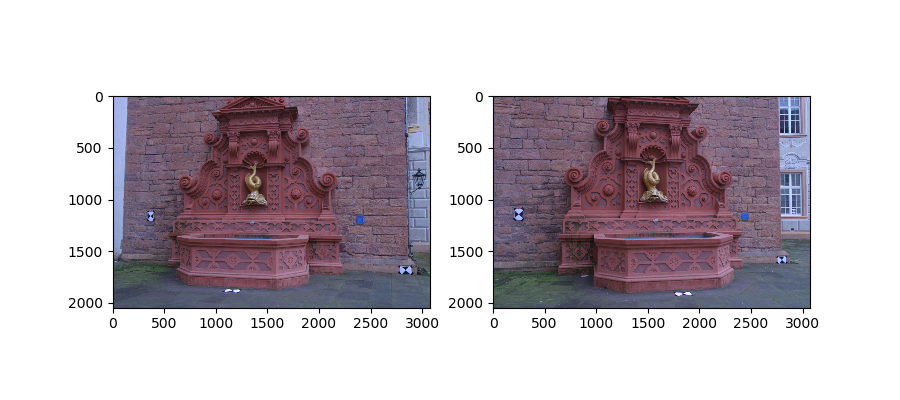

In [2]:
#Reading two images for reference
img1 = cv2.imread('./data/fountain-P11/images/0004.jpg')
img2 = cv2.imread('./data/fountain-P11/images/0006.jpg')

#Converting from BGR to RGB format
img1 = img1[:,:,::-1]
img2 = img2[:,:,::-1]

#NOTE: you can adjust appropriate figure size according to the size of your screen
fig,ax=plt.subplots(ncols=2,figsize=(9,4)) 
ax[0].imshow(img1)
ax[1].imshow(img2)

In [3]:
#Getting SIFT/SURF features for image matching (this might take a while)
kp1,desc1,kp2,desc2,matches=sfmcv2.GetImageMatches(img1,img2)

#Aligning two keypoint vectors
img1pts,img2pts,img1idx,img2idx=sfmcv2.GetAlignedMatches(kp1,desc1,kp2,desc2,matches)

## 1.1. Fundamental Matrix Computation

### 1.1.1. Eight Point Algorithm

In [4]:
img1pts_, img2pts_ = img1pts[:8], img2pts[:8]
Fgt, mask = cv2.findFundamentalMat(img1pts_,img2pts_,method=cv2.FM_8POINT)
F = sfmnp.EstimateFundamentalMatrix(img1pts_,img2pts_)

In [5]:
print F 
print 
print Fgt
np.testing.assert_allclose(F, Fgt, rtol=1e-7,atol=1e-3)

[[ -4.14372595e-08   8.28715213e-08  -8.43625823e-05]
 [  4.15072787e-07   2.95698948e-08   2.97788200e-03]
 [ -3.31657099e-04  -3.91844172e-03   1.00000000e+00]]

[[ -5.97892969e-09   7.76025698e-08  -1.20887915e-04]
 [  3.84560269e-07   2.73818759e-08   2.75620056e-03]
 [ -3.63233286e-04  -3.62885238e-03   1.00000000e+00]]


### 1.1.2. Normalized 8 Point Algorithm

In [6]:
F_normalized = sfmnp.EstimateFundamentalMatrixNormalized(img1pts_,img2pts_)

### 1.1.3. RANSAC (Random Sample Consensus)

In [7]:
Fgt, maskgt = cv2.findFundamentalMat(img1pts,img2pts,method=cv2.FM_RANSAC,param1=.1)
maskgt = maskgt.astype(bool).flatten()

F, mask = sfmnp.EstimateFundamentalMatrixRANSAC(img1pts,img2pts,.1,iters=20000)

In [8]:
print Fgt 
print 
print F

np.testing.assert_allclose(F,Fgt,rtol=1e-7,atol=1e-3)

[[ -7.81818018e-09   1.16620400e-07  -1.75262208e-04]
 [  3.42813088e-07   1.64778335e-08   2.80101788e-03]
 [ -3.02277699e-04  -3.65923057e-03   1.00000000e+00]]

[[ -1.01665352e-08   1.12024813e-07  -1.72186019e-04]
 [  3.47592411e-07   2.44359815e-08   2.77376777e-03]
 [ -2.98331637e-04  -3.64594461e-03   1.00000000e+00]]


## 1.2. Epipolar Lines Computation

In [9]:
lines2=sfmnp.ComputeEpiline(img1pts[mask],1,F)
lines1=sfmnp.ComputeEpiline(img2pts[mask],2,F)

## 1.3. Epipoles Computation

In [10]:
#to do later..

## 1.4. Visualizations I: Epipolar Geometry
### 1.4.1. Epipolar Lines

<IPython.core.display.Javascript object>


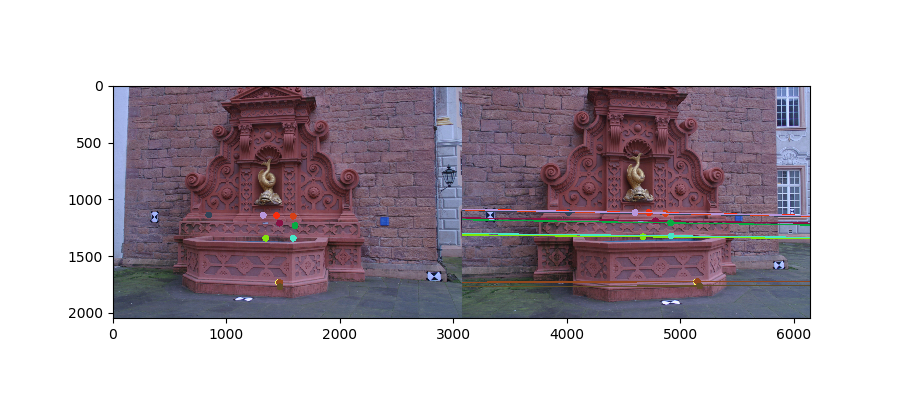

<IPython.core.display.Javascript object>


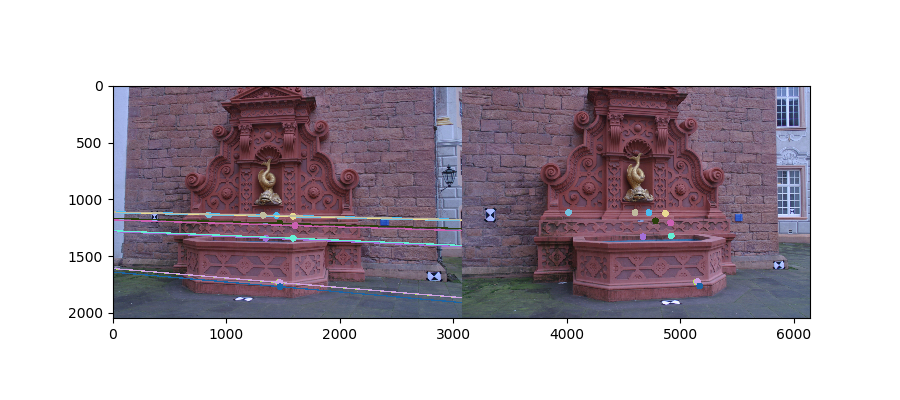

In [10]:
tup = ut.drawlines(img2,img1,lines2,img2pts[mask],img1pts[mask],drawOnly=10,
                   linesize=10,circlesize=30)
epilines2 = np.concatenate(tup[::-1],axis=1) #reversing the order of left and right images

plt.figure(figsize=(9,4))
plt.imshow(epilines2)

tup = ut.drawlines(img1,img2,lines1,img1pts[mask],img2pts[mask],drawOnly=10,
                   linesize=10,circlesize=30)
epilines1 = np.concatenate(tup,axis=1) 

plt.figure(figsize=(9,4))
plt.imshow(epilines1)

### 1.4.2. Epipoles

In [12]:
# to do later..

## 1.5. Pose Estimation

In [11]:
K = np.array([[2759.48,0,1520.69],[0,2764.16,1006.81],[0,0,1]])
E = K.T.dot(F.dot(K))

R1,R2,t = sfmnp.ExtractCameraPoses(E)
t = t[:,np.newaxis]

## 1.6. Visualizations II: Camera Poses

<IPython.core.display.Javascript object>


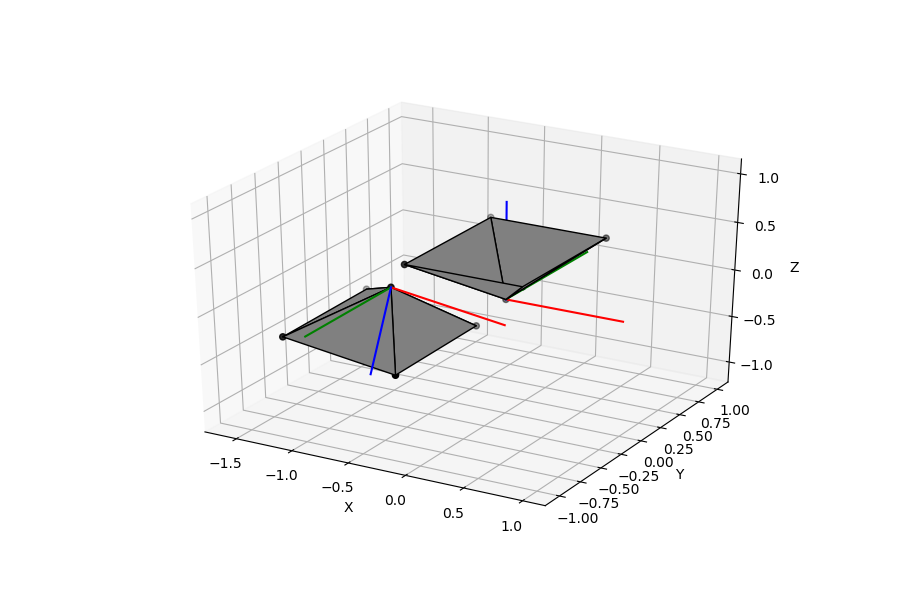

<IPython.core.display.Javascript object>


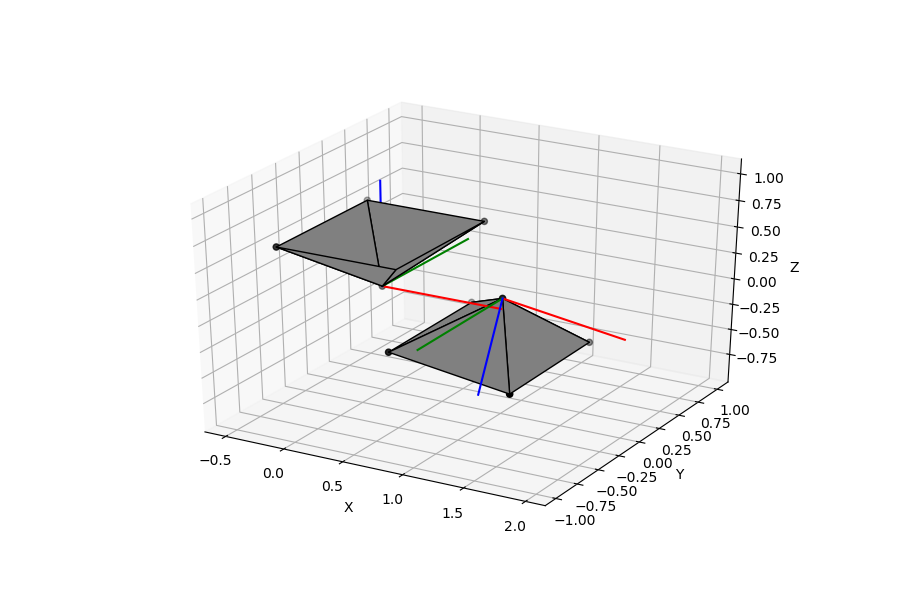

<IPython.core.display.Javascript object>


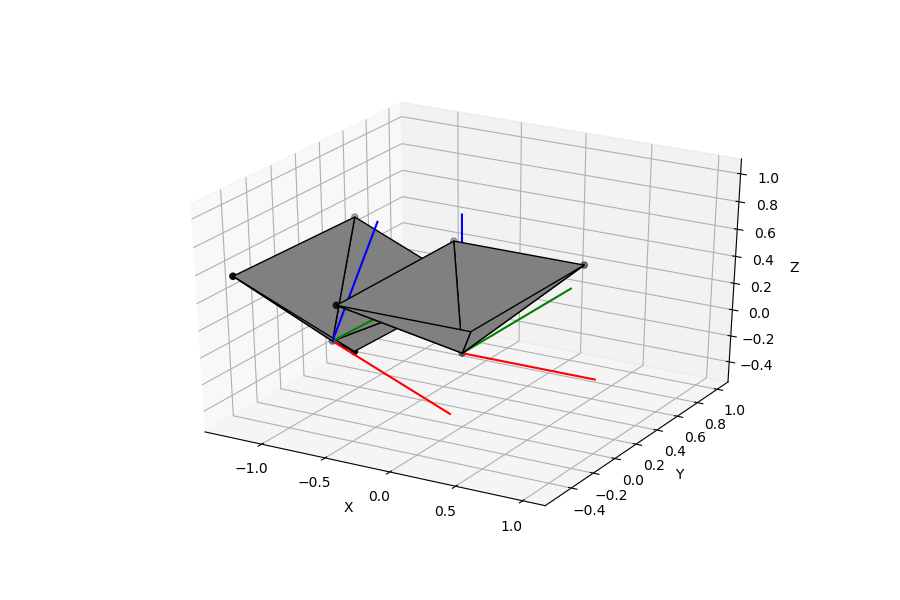

<IPython.core.display.Javascript object>


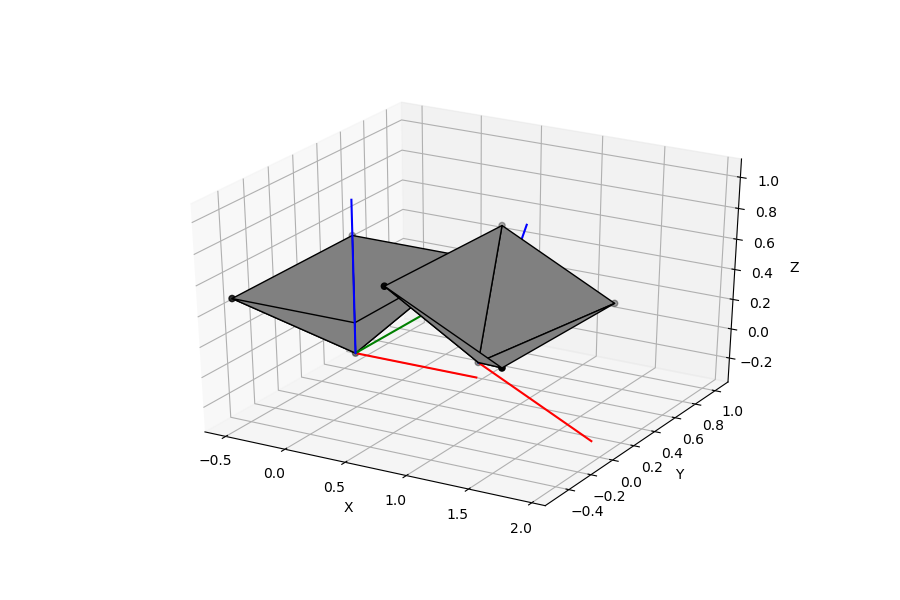

In [12]:
for R_ in [R1,R2]: 
    for t_ in [t,-t]:
        
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax)
        ut.PlotCamera(R_,t_[:,0],ax)

# 2. Triangulation: Estimating 3D Coordinates

## 2.1. DLT Method 

In [13]:
def GetTriangulatedPts(img1pts,img2pts,K,R,t,triangulateFunc): 
    img1ptsHom = cv2.convertPointsToHomogeneous(img1pts)[:,0,:]
    img2ptsHom = cv2.convertPointsToHomogeneous(img2pts)[:,0,:]

    img1ptsNorm = (np.linalg.inv(K).dot(img1ptsHom.T)).T
    img2ptsNorm = (np.linalg.inv(K).dot(img2ptsHom.T)).T

    img1ptsNorm = cv2.convertPointsFromHomogeneous(img1ptsNorm)[:,0,:]
    img2ptsNorm = cv2.convertPointsFromHomogeneous(img2ptsNorm)[:,0,:]
    
    pts4d = triangulateFunc(np.eye(3,4),np.hstack((R,t)),img1ptsNorm.T,img2ptsNorm.T)
    pts3d = cv2.convertPointsFromHomogeneous(pts4d.T)[:,0,:]
    
    return pts3d

In [14]:
pts3dgt = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t,cv2.triangulatePoints)
pts3d = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t,sfmnp.Triangulate)

In [15]:
print pts3dgt[:5]
print 
print pts3d[:5]
np.testing.assert_allclose(pts3d,pts3dgt,rtol=1e-7,atol=1e-3)

[[-0.03981376  0.45321779  1.71523337]
 [-0.04384345  0.17034874  2.23831671]
 [-0.03317883  0.45296103  1.7135997 ]
 [-0.14209492  0.27482848  2.21882702]
 [-0.60213277  0.12192049  2.45483599]]

[[-0.03981849  0.45326941  1.71533964]
 [-0.04384612  0.17035331  2.23832939]
 [-0.03318206  0.45301533  1.71371103]
 [-0.14210671  0.27482401  2.21881389]
 [-0.60213203  0.1218997   2.45472583]]


AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0.001

(mismatch 1.54975530179%)
 x: array([[ -3.981849e-02,   4.532694e-01,   1.715340e+00],
       [ -4.384612e-02,   1.703533e-01,   2.238329e+00],
       [ -3.318206e-02,   4.530153e-01,   1.713711e+00],...
 y: array([[ -3.981376e-02,   4.532178e-01,   1.715233e+00],
       [ -4.384345e-02,   1.703487e-01,   2.238317e+00],
       [ -3.317883e-02,   4.529610e-01,   1.713600e+00],...

In [16]:
configSet = [None,None,None,None]
configSet[0] = (R1,t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R1,t,sfmnp.Triangulate))
configSet[1] = (R1,-t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R1,-t,sfmnp.Triangulate))
configSet[2] = (R2,t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,t,sfmnp.Triangulate))
configSet[3] = (R2,-t,GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R2,-t,sfmnp.Triangulate))

## 2.2. Visualizing the triangulated points of configurations

<IPython.core.display.Javascript object>


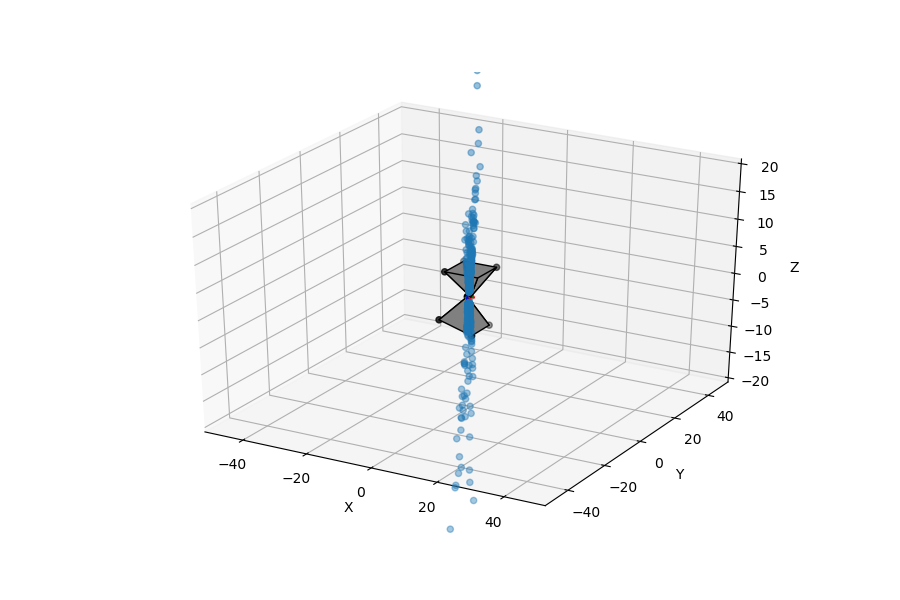

<IPython.core.display.Javascript object>


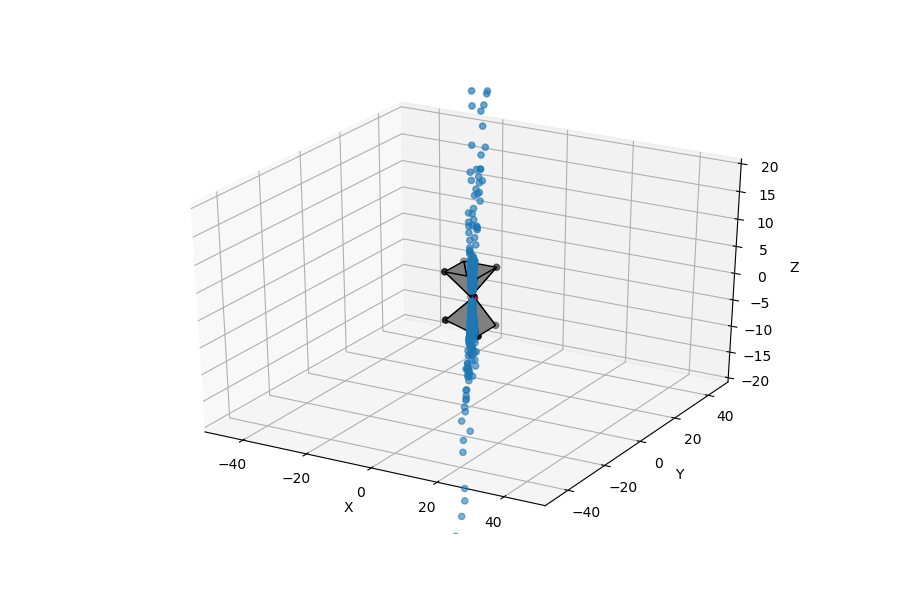

<IPython.core.display.Javascript object>


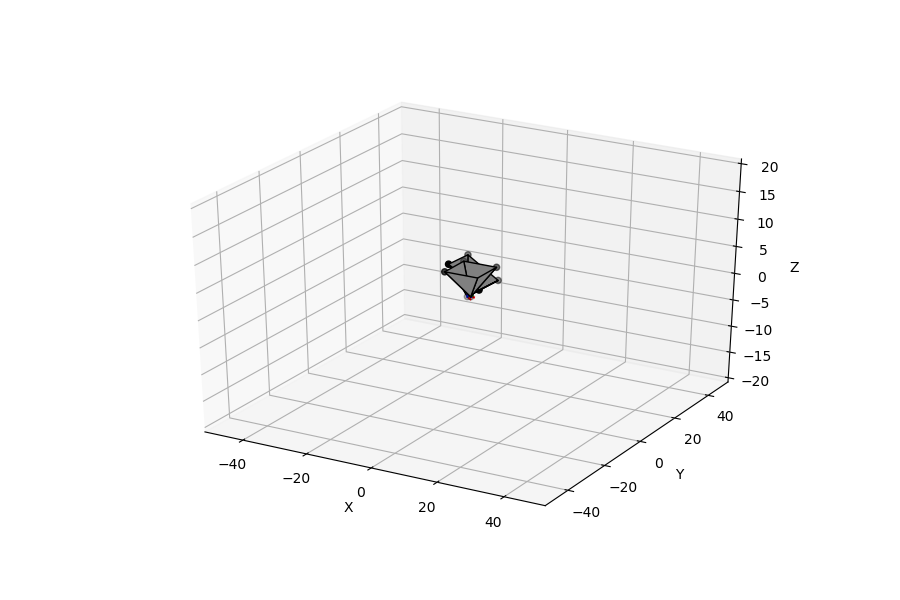

<IPython.core.display.Javascript object>


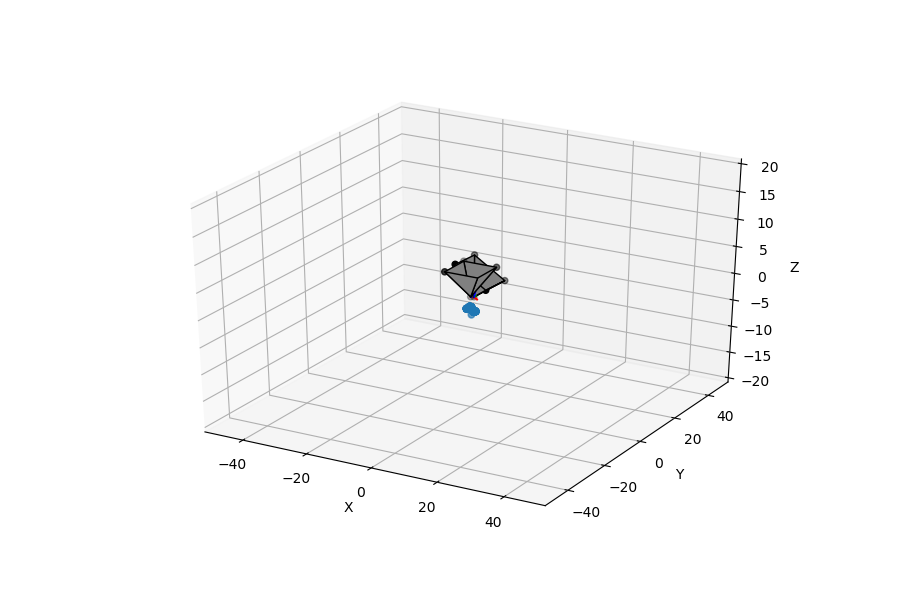

In [17]:
for cs in configSet: 
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax,scale=5,depth=5)
    ut.PlotCamera(cs[0],cs[1][:,0],ax,scale=5,depth=5)

    pts3d = cs[-1]
    ax.scatter3D(pts3d[:,0],pts3d[:,1],pts3d[:,2])

    ax.set_xlim(left=-50,right=50)
    ax.set_ylim(bottom=-50,top=50)
    ax.set_zlim(bottom=-20,top=20)

## 2.3. Camera Pose Disambiguation

In [18]:
_,Rgt,tgt,mask2=cv2.recoverPose(E,img1pts[mask],img2pts[mask],K)
R,t,count = sfmnp.DisambiguateCameraPose(configSet)

In [19]:
print R
print 
print Rgt
print 
print t
print 
print tgt 

np.testing.assert_allclose(R,Rgt,rtol=1e-7,atol=1e-4)
np.testing.assert_allclose(t,tgt,rtol=1e-7,atol=1e-4)

[[ 0.93211959 -0.01623008 -0.36178675]
 [ 0.00919673  0.99973392 -0.02115419]
 [ 0.36203382  0.01639098  0.93202084]]

[[ 0.93211959 -0.01623008 -0.36178675]
 [ 0.00919673  0.99973392 -0.02115419]
 [ 0.36203382  0.01639098  0.93202084]]

[[ 0.99574068]
 [ 0.02162115]
 [ 0.08962715]]

[[ 0.99574068]
 [ 0.02162115]
 [ 0.08962715]]


## 2.4. Visualizing Point Cloud Output

Since point cloud isn't effectively viewed in matplotlib, we can use an external software `meshlab` for better visualizations. For that, we'd need to transform our 3D points' format into meshlab-compatible format. We understand it can be rather tedious, so the function `pts2ply()` is already implemented for you.

In [20]:
pts3d = GetTriangulatedPts(img1pts[mask],img2pts[mask],K,R,t,sfmnp.Triangulate)
ut.pts2ply(pts3d,'out_2view.ply')

Now, please run `out.ply` with `meshlab` like so: `meshlab out.ply`

Output is also displayed below for reference

**NOTE**: Meshlab can be installed using `sudo apt-get install meshlab`

<img src="fountain.png">

# 3. Reprojection Error: Evaluation

## 3.1. Computation

In [21]:
img1ptsReproj = sfmnp.ComputeReprojections(pts3d,np.eye(3,3),np.zeros((3,1)),K)
img2ptsReproj = sfmnp.ComputeReprojections(pts3d,R,t,K)

In [22]:
err2 = sfmnp.ComputeReprojectionError(img2pts[mask], img2ptsReproj)
err1 = sfmnp.ComputeReprojectionError(img1pts[mask], img1ptsReproj)

err1, err2 

(2.2643695418643532, 2.3544959361030657)

## 3.2. Visualizations

<IPython.core.display.Javascript object>


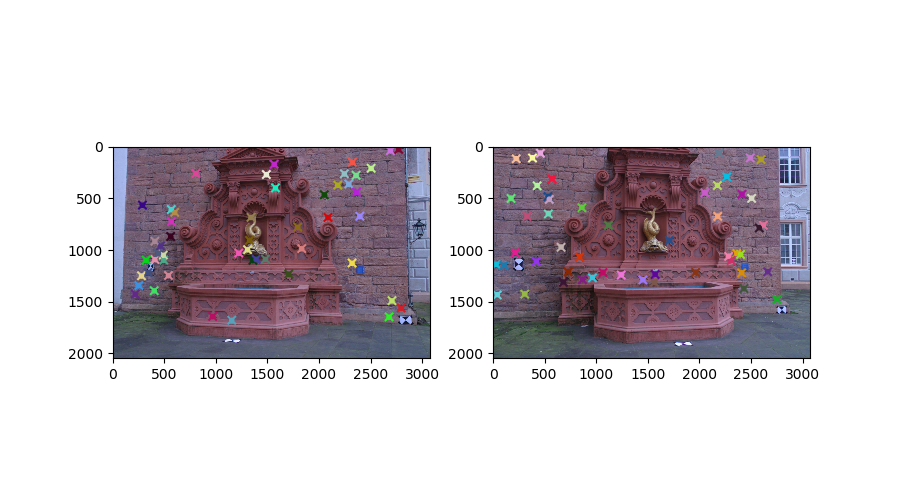

In [23]:
fig,ax=plt.subplots(ncols=2,figsize=(9,5))

ut.DrawCorrespondences(img1,img1pts[mask],img1ptsReproj,ax[0])
ut.DrawCorrespondences(img2,img2pts[mask],img2ptsReproj,ax[1])

# 4. Perspective-n-Point Algorithm: New Camera Registration

## 4.0. Reading third image and 2D-3D Matching using SIFT

<IPython.core.display.Javascript object>


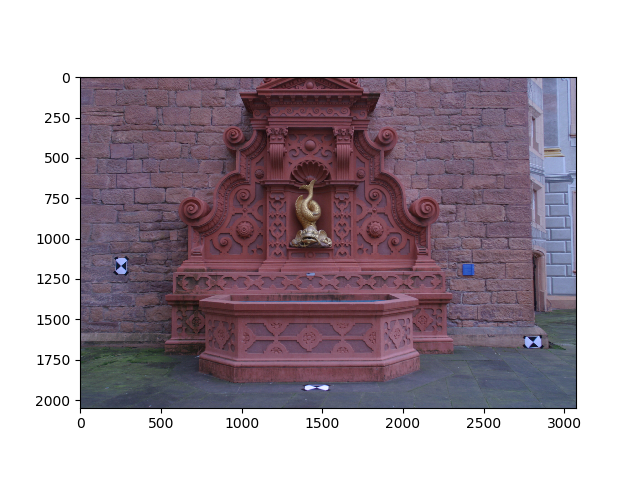

In [24]:
img3 = cv2.imread('./data/fountain-P11/images/0005.jpg')
img3 = img3[:,:,::-1]
surfer=cv2.xfeatures2d.SURF_create()
kp3, desc3 = surfer.detectAndCompute(img3,None)

plt.figure()
plt.imshow(img3)

img3pts,pts3dpts = sfmcv2.Find2D3DMatches(desc1,img1idx,desc2,img2idx,desc3,kp3,mask,pts3d)

## 4.1. Perspective-n-Point (PnP) Algorithm

### 4.1.1. Least Squares Solution

In [25]:
retval,Rvec,tnew = cv2.solvePnP(pts3dpts[:,np.newaxis],img3pts[:,np.newaxis],K,None,
                                flags=cv2.SOLVEPNP_DLS)

### 4.1.2. RANSAC

In [26]:
retval,Rvec,tnew,mask3 = cv2.solvePnPRansac(pts3dpts[:,np.newaxis],img3pts[:,np.newaxis],
                                            K,None,confidence=.99,flags=cv2.SOLVEPNP_DLS)
Rnew,_=cv2.Rodrigues(Rvec)

## 4.2. Visualizations

<IPython.core.display.Javascript object>


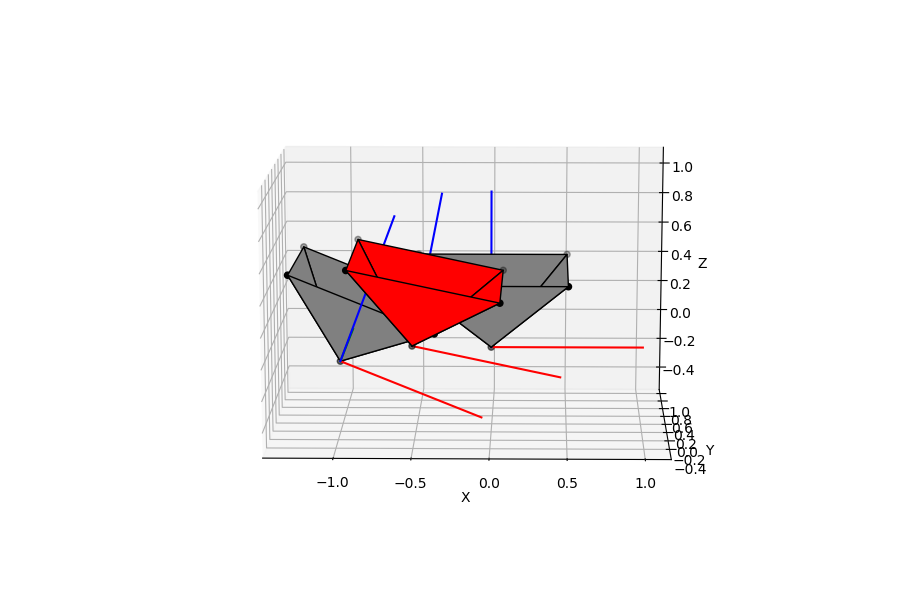

In [27]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ut.PlotCamera(np.eye(3,3),np.zeros((3,)),ax)
ut.PlotCamera(R,t[:,0],ax)
ut.PlotCamera(Rnew,tnew[:,0],ax,faceColor='red')

# 5. Re-triangulation

In [29]:
kpNew, descNew = kp3, desc3 

kpOld,descOld = kp1,desc1
ROld, tOld = np.eye(3), np.zeros((3,1))

accPts = []
for (ROld, tOld, kpOld, descOld) in [(np.eye(3),np.zeros((3,1)), kp1,desc1),(R,t,kp2,desc2)]: 
    
    #Matching between old view and newly registered view.. 
    print '[Info]: Feature Matching..'
    matcher = cv2.BFMatcher(crossCheck=True)
    matches = matcher.match(descOld, desc3)
    matches = sorted(matches, key = lambda x:x.distance)
    imgOldPts, imgNewPts, _, _ = sfmcv2.GetAlignedMatches(kpOld,descOld,kpNew,
                                                          descNew,matches)
    
    #Pruning the matches using fundamental matrix..
    print '[Info]: Pruning the Matches..'
    F,mask=cv2.findFundamentalMat(imgOldPts,imgNewPts,method=cv2.FM_RANSAC,param1=.1,param2=.99)
    mask = mask.flatten().astype(bool)
    imgOldPts=imgOldPts[mask]
    imgNewPts=imgNewPts[mask]
    
    #Triangulating new points
    print '[Info]: Triangulating..'
    newPts = sfmnp.GetTriangulatedPts(imgOldPts,imgNewPts, K, Rnew,tnew,cv2.triangulatePoints,ROld,tOld)
    
    #Adding newly triangulated points to the collection
    accPts.append(newPts)

[Info]: Feature Matching..
[Info]: Pruning the Matches..
[Info]: Triangulating..
[Info]: Feature Matching..
[Info]: Pruning the Matches..
[Info]: Triangulating..


In [36]:
#Adding the original 2-view-sfm point cloud and saving the whole collection
accPts.append(pts3d)
ut.pts2ply(np.concatenate((accPts),axis=0),'test.ply')

# 6. Final Result 

<img src="fountain_dense.png">